In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import normflows as nf
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from tqdm import tqdm
import random
from torch.utils.data import DataLoader
print(f"Using device: {device}")

/home/pgrad2/2448355h/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Using device: cuda


In [2]:
def sim_revexp_u_mgpd(n, d, a, beta, sig, gamma, MGPD=True, std=False):
    lam = np.exp(beta)
    Y = np.zeros((n, d))
    C = 1 / np.min(lam)
    k = 0

    while k < n:
        U = np.random.uniform(0, 1, d)
        W = (U ** a) / lam
        R = np.random.uniform(0, C)
        
        Ind = R < np.max(W)
        
        if Ind:
            Y[k, :] = W / R
            k += 1

    if std and not MGPD:
        return np.log(Y)

    X = []
    for j in range(d):
        if gamma[j] != 0:
            X.append(sig[j] * (Y[:, j] ** gamma[j] - 1) / gamma[j])
        else:
            X.append(sig[j] * np.log(Y[:, j]))
    X = np.column_stack(X)

    if MGPD and not std:
        return X
    if std and MGPD:
        return {'X': X, 'Z': np.log(Y)}

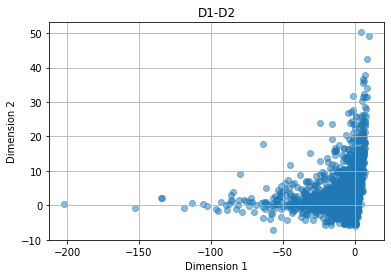

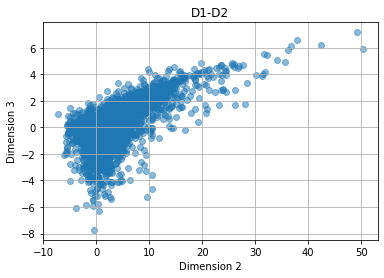

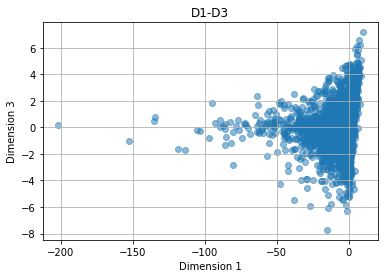

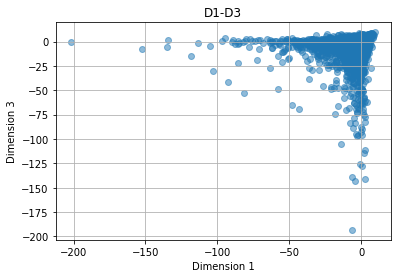

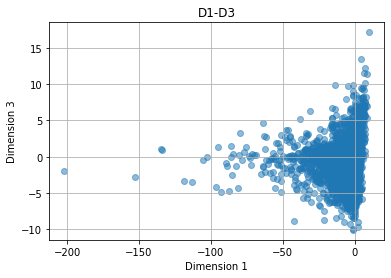

In [3]:
n_samples = 5000

# d = 2
# a = np.array([3,0.5])
# beta = np.array([0, 0])
# sig = np.array([2,3])
# gamma = np.array([-0.1, 0.2])

d = 10
a = np.array([3,0.5,1,2,1.5,  3,0.5,1,2,1.5])
beta = np.array([0, 0,0,0,0,   0, 0,0,0,0])
sig = np.array([2,3,1,2.5,1.5,   2,3,1,2.5,1.5  ])
gamma = np.array([-0.1, 0.2, 0, -0.2, 0.1,  -0.1, 0.2, 0, -0.2, 0.1])

samples = sim_revexp_u_mgpd(n_samples, d, a, beta, sig, gamma)

# Visualize the samples
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('D1-D2')
plt.grid(True)
plt.show()

plt.scatter(samples[:, 1], samples[:, 2], alpha=0.5)
plt.xlabel('Dimension 2')
plt.ylabel('Dimension 3')
plt.title('D1-D2')
plt.grid(True)
plt.show()

plt.scatter(samples[:, 0], samples[:, 2], alpha=0.5)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 3')
plt.title('D1-D3')
plt.grid(True)
plt.show()

plt.scatter(samples[:, 0], samples[:, 3], alpha=0.5)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 3')
plt.title('D1-D3')
plt.grid(True)
plt.show()

plt.scatter(samples[:, 0], samples[:, 4], alpha=0.5)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 3')
plt.title('D1-D3')
plt.grid(True)
plt.show()

In [4]:
class DataTransform(nn.Module):
    """
    Elementwise transform:
      If gamma_j = 0:
        forward_transform(y_j): x_j = sigma_j * y_j
        inverse_transform(x_j): y_j = x_j / sigma_j
      Otherwise (gamma_j != 0):
        forward_transform(y_j): x_j = sigma_j * [exp(gamma_j * y_j) - 1] / gamma_j
        inverse_transform(x_j): y_j = (1 / gamma_j)* log(1 + gamma_j * x_j / sigma_j)
    """

    def __init__(self, dim, device):
        super().__init__()
        self.dim = dim
        # Store log_sigma so sigma = exp(log_sigma) > 0
        self.log_sigma = nn.Parameter(torch.zeros(dim, device=device))
#         self.log_sigma = torch.zeros(dim, device=device)
        # gamma can be any real value
        self.gamma = nn.Parameter(torch.zeros(dim, device=device)+1e-6)
#         self.gamma = torch.zeros(dim, device=device)+1e-6

    def forward_transform(self, y):
        """
        y -> x
        """
        sigma = torch.exp(self.log_sigma)  # shape (dim,)
        sigma = torch.clamp(sigma, min = 1e-6, max = 1e6)
        gamma = self.gamma                # shape (dim,)
        gamma = torch.clamp(gamma, min = -0.5, max = 0.5)
        gamma = gamma.sign() * torch.max(gamma.abs(), torch.tensor(1e-6, device=gamma.device))
        
        # We'll do it elementwise, but in a vectorized way.
        # y and x are shape (batch_size, dim).
    
        x_out = torch.zeros_like(y)

        # For gamma_j = 0 => x_j = sigma_j * y_j
        # For gamma_j != 0 => x_j = sigma_j*(exp(gamma_j*y_j) - 1)/gamma_j
        # We can use torch.where(...) to handle each dimension separately.

        # Expand so shapes match for broadcasting
        sigma = sigma.unsqueeze(0)  # (1, dim)
        gamma = gamma.unsqueeze(0)  # (1, dim)

        # Exponential case: x_j = sigma_j*(exp(gamma_j*y_j) - 1)/gamma_j
        x_out = sigma * (torch.exp(torch.clamp(gamma * y, max=10)) - 1.0) / gamma

        return x_out

    def inverse_transform(self, x):
        """
        x -> y
        """
        sigma = torch.exp(self.log_sigma)  # shape (dim,)
        sigma = torch.clamp(sigma, min = 1e-6, max = 1e6)
        gamma = self.gamma                # shape (dim,)
        gamma = torch.clamp(gamma, min = -0.5, max = 0.5)
        gamma = gamma.sign() * torch.max(gamma.abs(), torch.tensor(1e-6, device=gamma.device))

        y_out = torch.zeros_like(x)

        # For gamma_j = 0 => y_j = x_j / sigma_j
        # For gamma_j != 0 => y_j = (1/gamma_j)* log(1 + gamma_j*x_j / sigma_j)
        sigma = sigma.unsqueeze(0)  # (1, dim)
        gamma = gamma.unsqueeze(0)  # (1, dim)

#         gamma_is_zero = (gamma.abs() < 1e-6)

#         # Linear case: y_j = x_j / sigma_j
#         y_linear = x / sigma

        # Exponential (inverse) case: y_j = (1/gamma_j)* log(1 + gamma_j*x_j / sigma_j)
        inside = 1.0 + (gamma * x) / sigma
        inside = torch.clamp(inside, min=1e-12) 
        y_out = (1.0 / gamma) * torch.log(inside)

#         y_out = torch.where(gamma_is_zero, y_linear, y_exp)
        return y_out

    def forward(self, z, reverse=False):
        """
        For normflows compatibility:
          - If reverse=False: we do y->x
          - If reverse=True: we do x->y
        """
        if not reverse:
            return self.forward_transform(z)
        else:
            return self.inverse_transform(z)

In [5]:
class T_mGPD_NF(nn.Module):
    """
    Interpreting:
       x = observed data (size=dim)
       y = standardized data
    We have:

      DataTransform.forward_transform(y)   = x
      DataTransform.inverse_transform(x)   = y

    So in 'forward(x)', to get minus log-likelihood of data x:
       1) We do y = inverse_transform(x)
       2) log_p_flow(y) = flow_model.log_prob(y)
       3) The log-det Jacobian of x->y is the sum of log(d y_i / d x_i).
          We'll compute that from the known formula for inverse_transform.
    """
    def __init__(self, dim, flow, device, s_min , s_max, num_integration_points, penalty_lambda):
        super().__init__()
        self.dim = dim
        # Learnable data transformation
        self.data_transform = DataTransform(dim, device)
        # RealNVP flow model
        self.flow_model = flow
        self.device = device
        self.s_values = torch.linspace(s_min, s_max, num_integration_points, device=device)
        self.s_values = self.s_values.reshape(-1, 1, 1)
        self.s_min = s_min
        self.s_max = s_max
        self.num_integration_points = num_integration_points
        self.penalty_lambda = penalty_lambda
        
    def log_integral_f_T(self, data):
            # Expand batch_x to match s_values
        batch_size = data.shape[0]
        dim = data.shape[1]
        
        x_expanded = data.unsqueeze(0)  # Shape (1, effective_batch_size, dim)
        x_expanded = x_expanded.expand(self.num_integration_points, -1, -1)  # Shape (num_points, batch_size, dim)

        # Expand s_values to match batch size and dimension
        s_expanded = self.s_values.expand(-1, batch_size, 1)  # Shape (num_points, batch_size, 1)

        # Compute x + s for all s_values
        x_plus_s = x_expanded + s_expanded  # Broadcasting over the last dimension
        x_plus_s = x_plus_s.reshape(-1, dim)  # Flatten to (num_points * batch_size, dim)

        log_f_T = self.flow_model.log_prob(x_plus_s)  # Shape (num_points * batch_size,)
        log_integrand = log_f_T.reshape(self.num_integration_points, batch_size)
        
        # 1. log-sum-exp over 'num_points' dimension
        max_vals, _ = torch.max(log_integrand, dim=0, keepdim=True)  # shape (1, batch_size)
        stable_exp = torch.exp(log_integrand - max_vals)             # shape (num_points, batch_size)
        
        delta_s = (self.s_max - self.s_min) / (self.num_integration_points - 1)
        sum_exp = torch.trapz(stable_exp, dx=delta_s, dim=0)         # shape (batch_size,)
        # 2. Now put the max_vals back in:
        log_integral = max_vals.squeeze(0) + torch.log(sum_exp + 1e-40)  # shape (batch_size,)
        
        return log_integral
    
    def log_prob_T_mGPD_std(self, data):
        log_integral = self.log_integral_f_T(data)
        max_T = torch.max(data, dim=1)[0]
        
        log_prob = log_integral - max_T
        return log_prob
    
    
        

    def forward(self, x_data):
        """
        Return minus log p_data(x_data).
        We do:
          y = T_inv(x_data)  [since T_inv is x->y]
          log p_data(x_data) = log p_flow(y) + log|det(d y / d x)|
        """
        # 1) x->y
        y = self.data_transform.inverse_transform(x_data)

        # 2) log prob under flow
        log_prob_y = self.log_prob_T_mGPD_std(y)

        # 3) log | det dy/dx |
        #    From y_i = 1/gamma_i * log(1 + gamma_i*x_i / sigma_i),
        #    dy_i/dx_i = 1 / [sigma_i + gamma_i * x_i].
        sigma = torch.exp(self.data_transform.log_sigma)  # shape (dim,)
        gamma = self.data_transform.gamma                 # shape (dim,)

        sigma = torch.clamp(sigma, min = 0.01, max = 100)
        
        gamma = torch.clamp(gamma, min = -0.5, max = 0.5)
        gamma = gamma.sign() * torch.max(gamma.abs(), torch.tensor(1e-6, device=gamma.device))

        sigma = sigma.unsqueeze(0)  # (1, dim)
        gamma = gamma.unsqueeze(0)  # (1, dim)

        # Build inside = sigma + gamma*x
        inside = sigma + gamma * x_data

        # log_abs_detJ per sample = - sum_j log(inside_j)
        log_abs_detJ = -torch.sum(torch.log(inside.abs() + 1e-12), dim=1)
        
        # => log p(x_data) = log p(y) + log|det dy/dx|
        log_prob_x = log_prob_y + log_abs_detJ
        
        ######## Soft penalty: penalize negative (sigma_j + gamma_j*x_j)
        negative_part = torch.relu(-inside)  # = max(0, -(inside)) => positive if inside<0
        # penalty = sum_j [ negative_part^2 ] over j, average over batch
        penalty_per_sample = (negative_part ** 2).sum(dim=1)
        penalty = self.penalty_lambda * penalty_per_sample.mean()
        
        return -log_prob_x.mean() +  penalty 

    def sample(self, n_samples=1):
        """
        Sample from the learned distribution in x-space by:
          1) Sample y ~ flow
          2) Convert y->x using forward_transform
        """
        self.flow_model.eval()
        samples_T,_ = self.flow_model.sample(n_samples)
        self.flow_model.train()
        
        samples_T_max = torch.max(samples_T,axis=1,keepdim=True)[0]
        samples_T_1 = samples_T - samples_T_max
        
        samples_E  = torch.empty(n_samples, device=self.device)
        samples_E = samples_E.exponential_(1.0).unsqueeze(1)
        
        samples_y = samples_E + samples_T_1

        samples_x = self.data_transform.forward_transform(samples_y)  # y->x
        return samples_x, samples_y, samples_T



In [6]:
data = torch.tensor(samples, dtype=torch.float, device = device)

In [7]:
memory = torch.cuda.memory_allocated(device) /10**9
print('{:.2f}G GPU memory allocated'.format(memory))

0.00G GPU memory allocated


In [23]:
dim = 10

base = nf.distributions.DiagGaussian(dim)
# base = my_DiagGaussian(dim)


num_layers = 12
torch.manual_seed(0)

latent_size = dim
b = torch.Tensor([1 if i % 2 == 0 else 0 for i in range(latent_size)])
flows = []
for i in range(num_layers):
    s = nf.nets.MLP([latent_size, 3 * latent_size, latent_size], init_zeros=True, output_fn='tanh')
    t = nf.nets.MLP([latent_size, 3 * latent_size, latent_size], init_zeros=True, output_fn='tanh')
    if i % 2 == 0:
        flows += [nf.flows.MaskedAffineFlow(b, t, s)]
    else:
        flows += [nf.flows.MaskedAffineFlow(1 - b, t, s)]
    flows += [nf.flows.ActNorm(latent_size)]


f_T_model = nf.NormalizingFlow(base, flows)
f_T_model = f_T_model.to(device)

# f_T_model.sample(num_samples=2 ** 7)
# z_np = z.to('cpu').data.numpy()
# plt.figure(figsize=(15, 15))
# plt.hist2d(z_np[:, 0].flatten(), z_np[:, 1].flatten(), (200, 200), range=[[-3, 3], [-3, 3]])
# plt.gca().set_aspect('equal', 'box')
# plt.show()

batch_size = 128
loss_history = []
epochs = 30

model = T_mGPD_NF(dim=dim, flow =f_T_model, device=device, s_min=-10,
                  s_max = 10, num_integration_points=1000, penalty_lambda=100000)


optimizer = torch.optim.Adam([
    {'params': model.flow_model.parameters(), 'lr': 2e-2},  # Flow layers
    {'params': model.data_transform.log_sigma, 'lr': 2e-2},  # Faster for log_sigma
    {'params': model.data_transform.gamma, 'lr': 2e-2}       # Faster for gamma
], weight_decay = 1e-5 )
# for name, param in model.named_parameters():
#     print(name, param)



Epoch 1/30, Loss: 2948768.5080
Epoch 0 - Learning Rate: 0.02


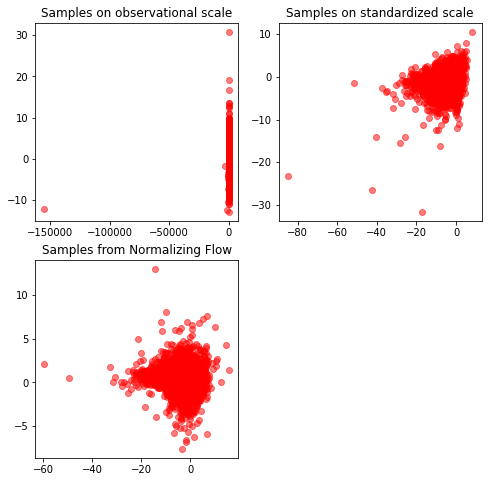

Epoch 2/30, Loss: 121.0567
Epoch 1 - Learning Rate: 0.019945218953682734


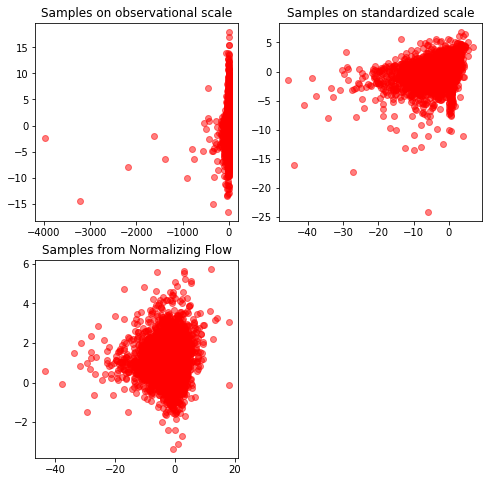

Epoch 3/30, Loss: 119.0791
Epoch 2 - Learning Rate: 0.019781476007338056


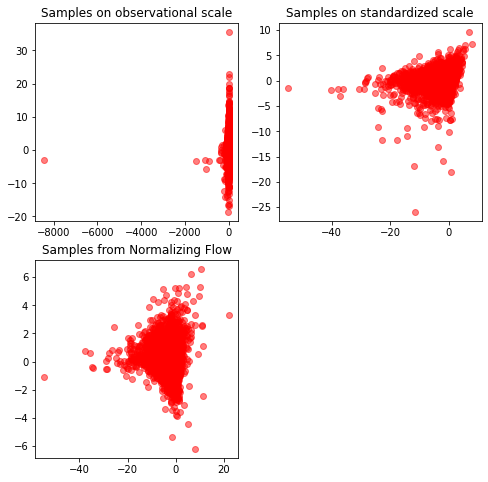

Epoch 4/30, Loss: 117.9831
Epoch 3 - Learning Rate: 0.019510565162951538


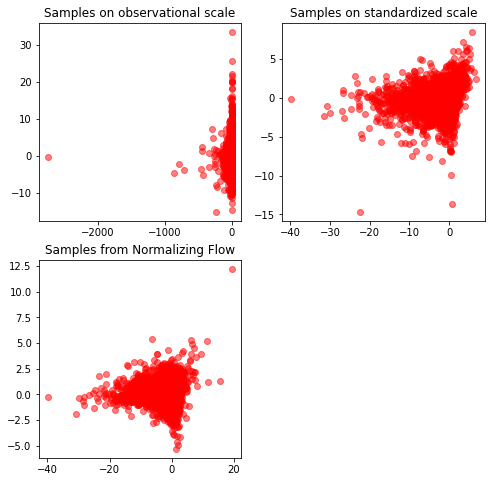

Epoch 5/30, Loss: 116.6530
Epoch 4 - Learning Rate: 0.019135454576426007


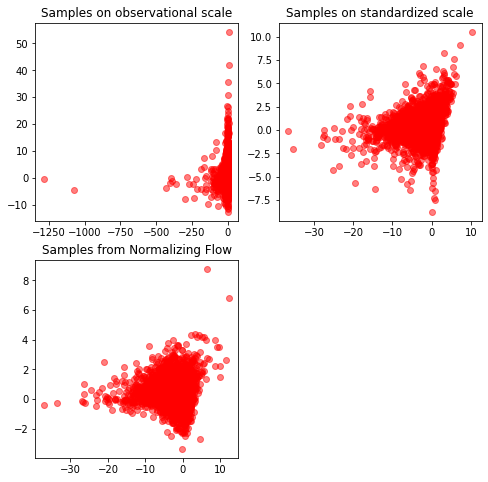

Epoch 6/30, Loss: 116.6189
Epoch 5 - Learning Rate: 0.01866025403784439


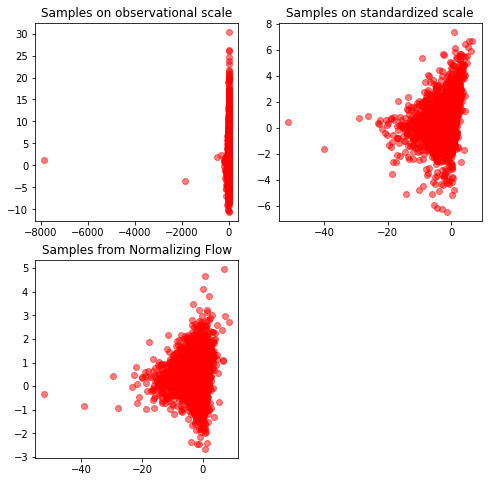

Epoch 7/30, Loss: 115.5932
Epoch 6 - Learning Rate: 0.018090169943749474


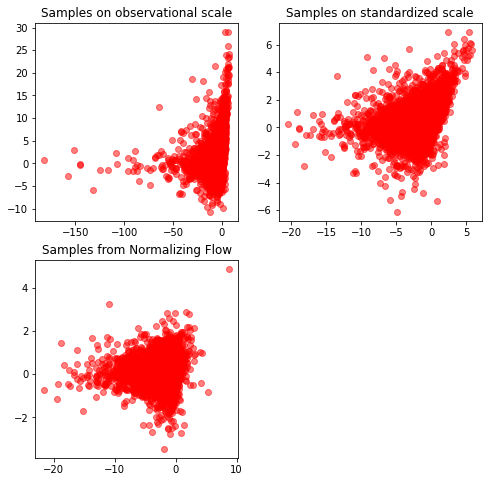

Epoch 8/30, Loss: 115.5364
Epoch 7 - Learning Rate: 0.01743144825477394


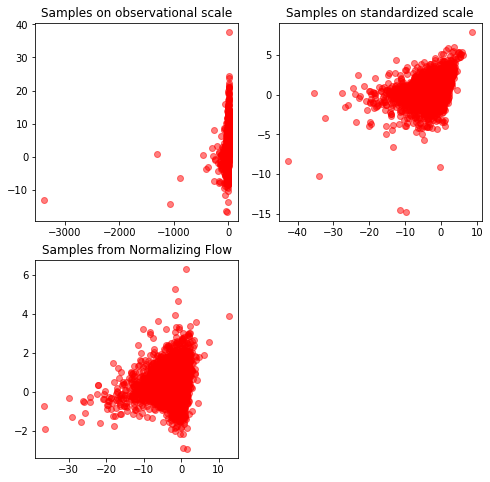

Epoch 9/30, Loss: 115.1202
Epoch 8 - Learning Rate: 0.016691306063588582


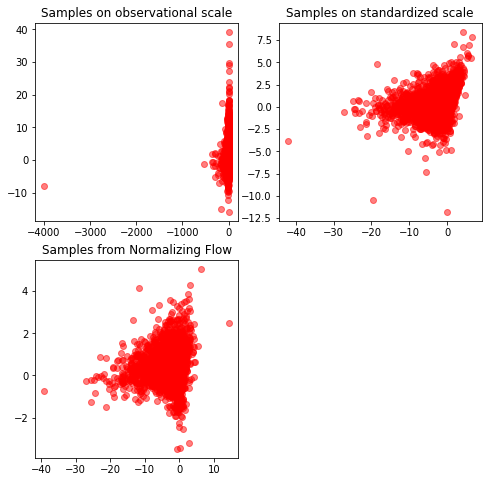

Epoch 10/30, Loss: 114.9268
Epoch 9 - Learning Rate: 0.01587785252292473


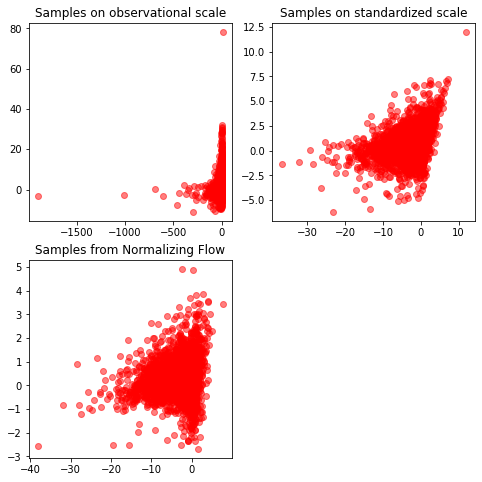

Epoch 11/30, Loss: 114.6557
Epoch 10 - Learning Rate: 0.014999999999999998


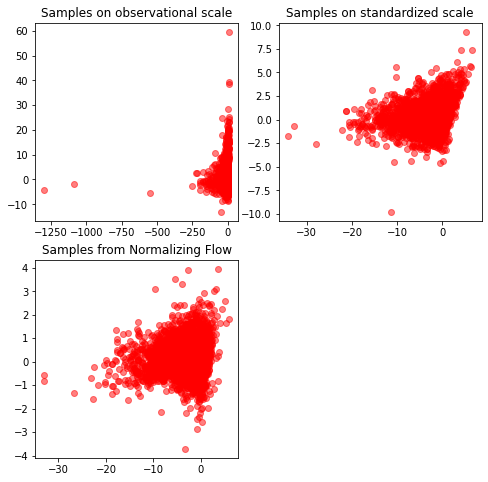

Epoch 12/30, Loss: 114.6402
Epoch 11 - Learning Rate: 0.014067366430758002


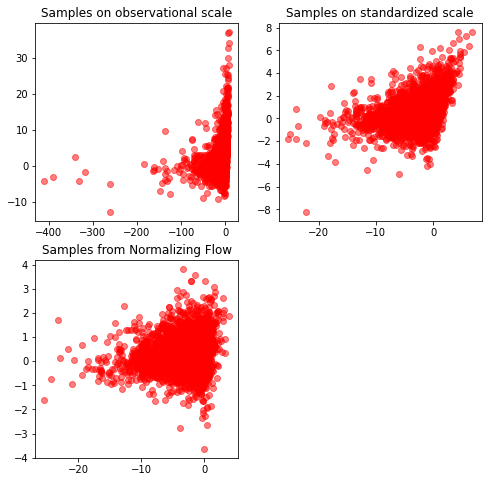

Epoch 13/30, Loss: 114.3104
Epoch 12 - Learning Rate: 0.013090169943749473


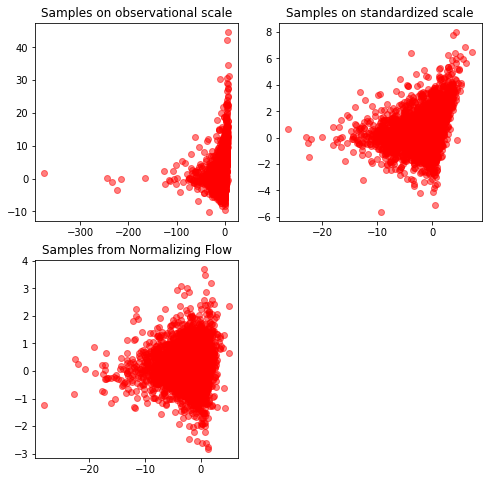

Epoch 14/30, Loss: 114.2925
Epoch 13 - Learning Rate: 0.012079116908177591


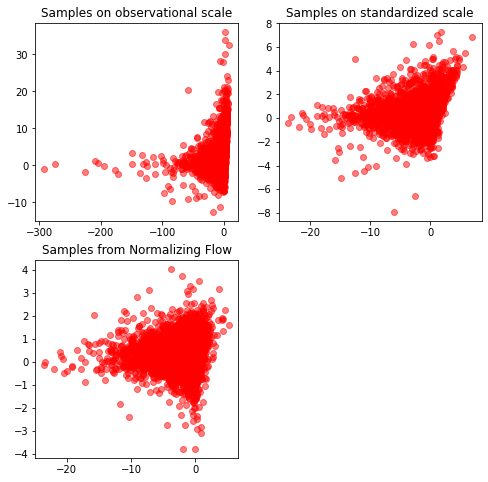

Epoch 15/30, Loss: 113.7698
Epoch 14 - Learning Rate: 0.011045284632676535


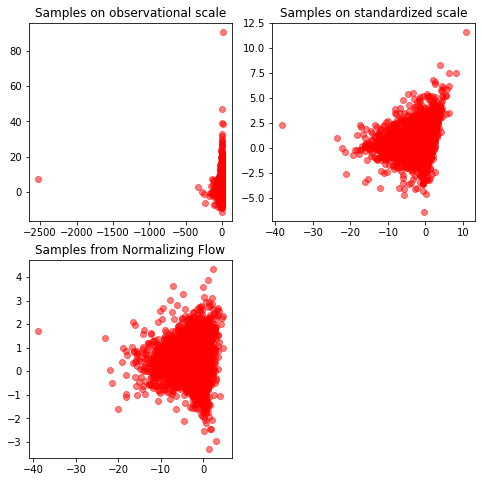

Epoch 16/30, Loss: 113.6682
Epoch 15 - Learning Rate: 0.010000000000000002


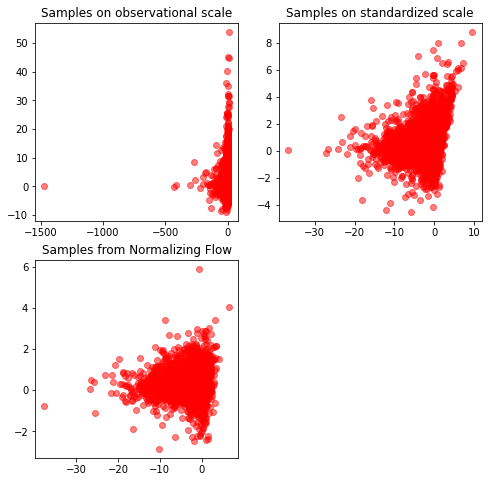

Epoch 17/30, Loss: 113.7208
Epoch 16 - Learning Rate: 0.008954715367323467


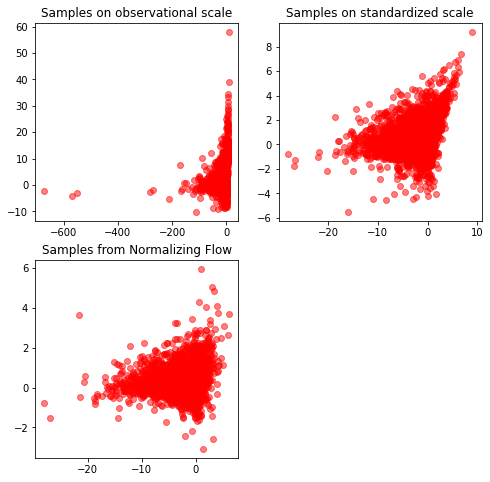

Epoch 18/30, Loss: 113.5836
Epoch 17 - Learning Rate: 0.007920883091822406


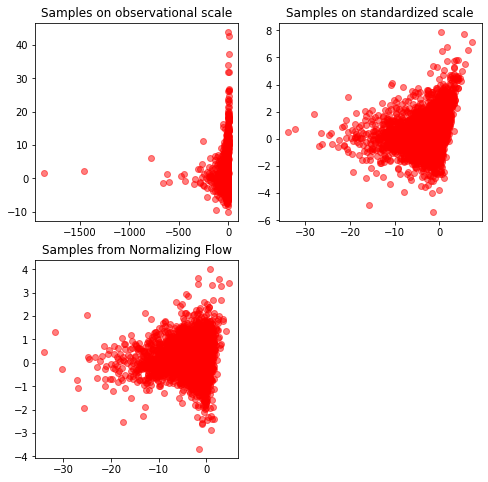

Epoch 19/30, Loss: 113.2441
Epoch 18 - Learning Rate: 0.006909830056250526


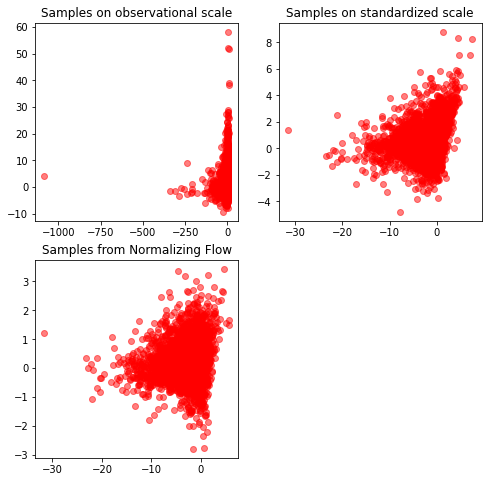

Epoch 20/30, Loss: 112.7501
Epoch 19 - Learning Rate: 0.0059326335692419995


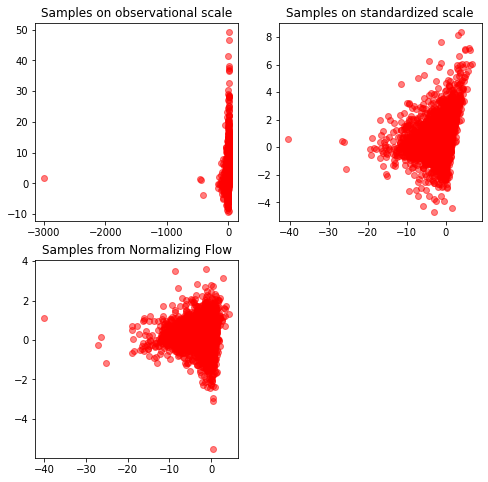

Epoch 21/30, Loss: 112.6898
Epoch 20 - Learning Rate: 0.005000000000000002


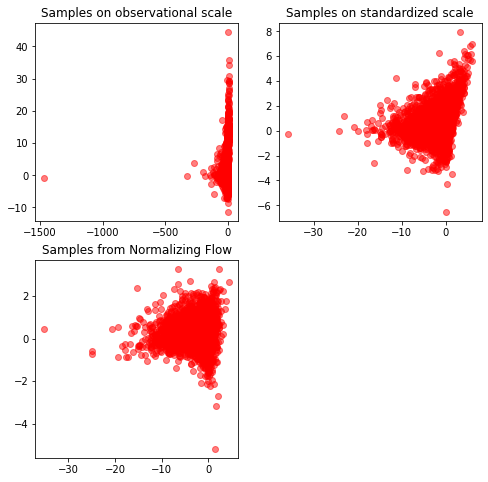

Epoch 22/30, Loss: 112.3636
Epoch 21 - Learning Rate: 0.0041221474770752695


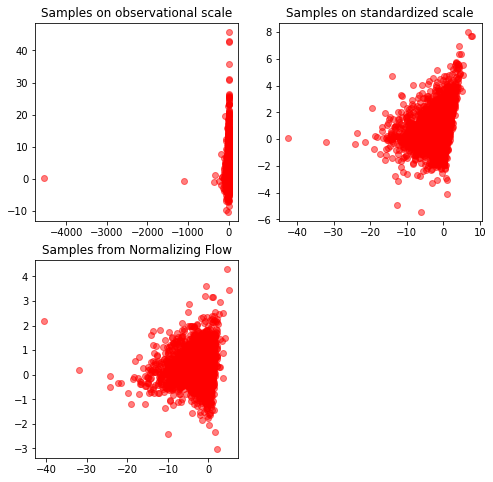

Epoch 23/30, Loss: 111.9273
Epoch 22 - Learning Rate: 0.0033086939364114208


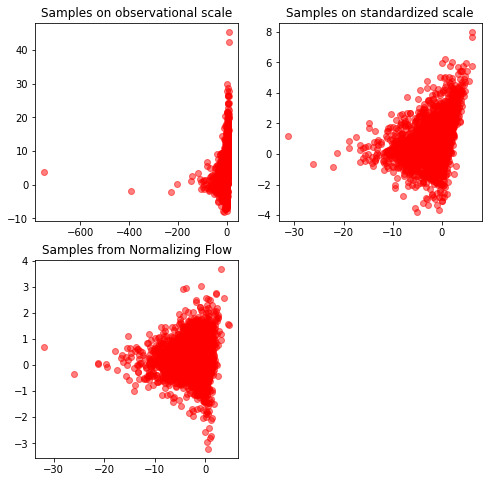

Epoch 24/30, Loss: 111.7735
Epoch 23 - Learning Rate: 0.0025685517452260598


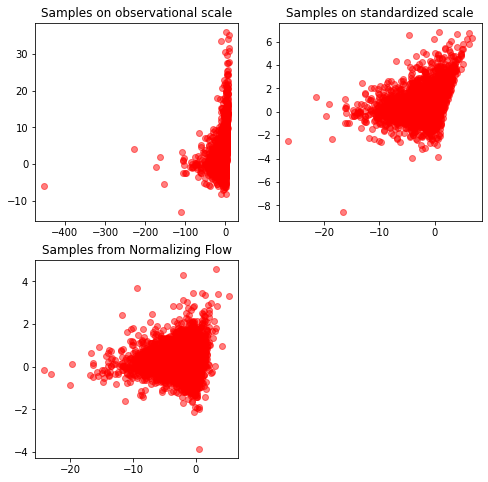

Epoch 25/30, Loss: 111.8862
Epoch 24 - Learning Rate: 0.0019098300562505268


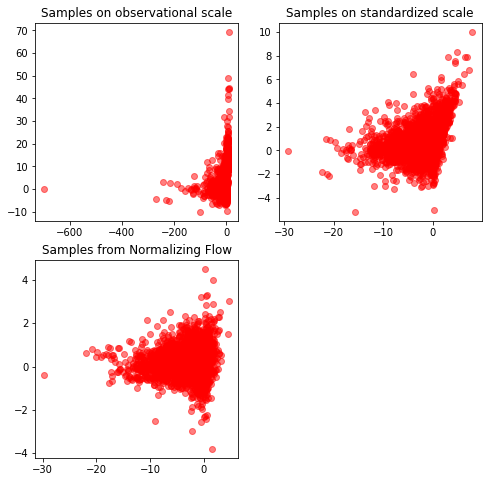

Epoch 26/30, Loss: 111.7005
Epoch 25 - Learning Rate: 0.001339745962155613


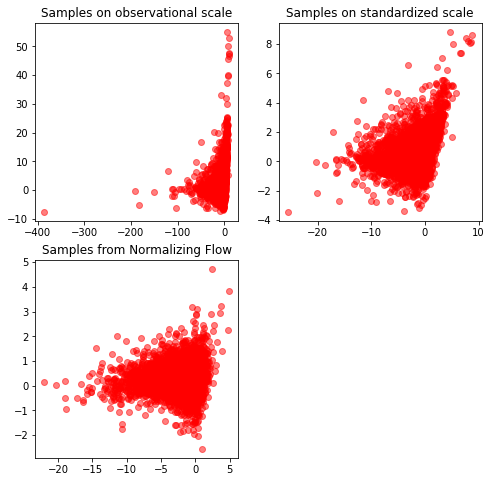

Epoch 27/30, Loss: 111.5032
Epoch 26 - Learning Rate: 0.0008645454235739903


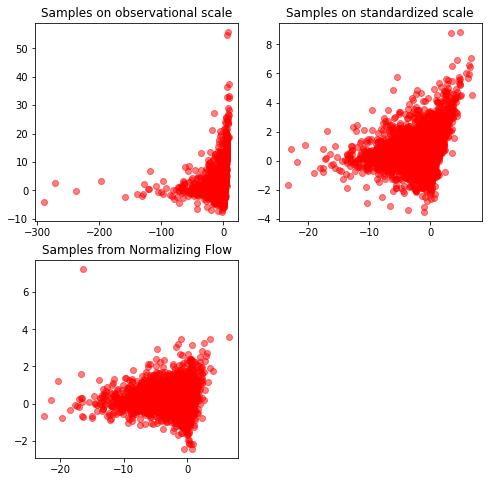

Epoch 28/30, Loss: 111.4816
Epoch 27 - Learning Rate: 0.0004894348370484647


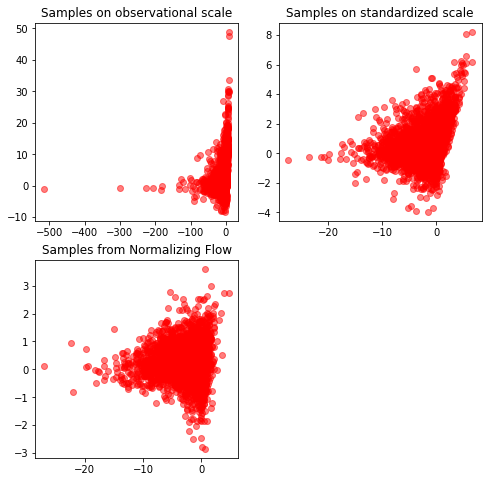

Epoch 29/30, Loss: 111.1618
Epoch 28 - Learning Rate: 0.00021852399266194313


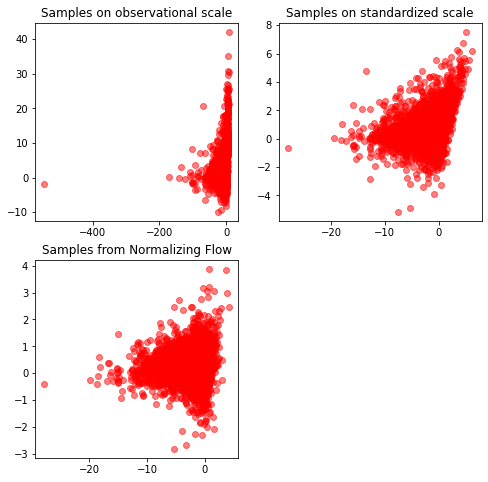

Epoch 30/30, Loss: 111.3535
Epoch 29 - Learning Rate: 5.478104631726599e-05


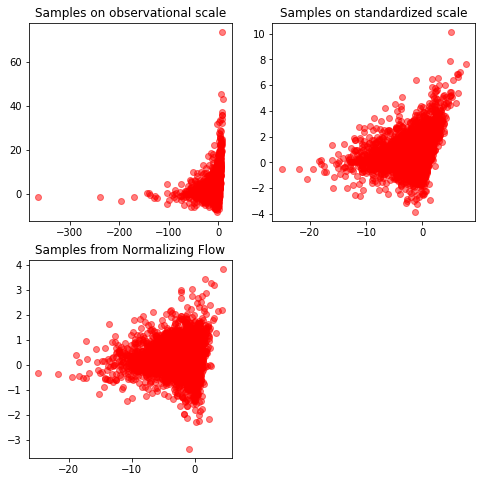

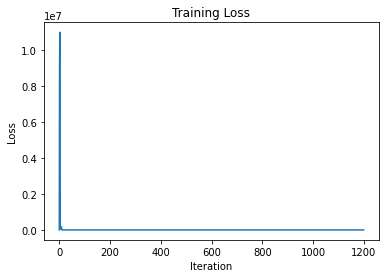

In [24]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, mode='min', factor=0.5, patience=10, verbose=True
# )

seed = 123
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # for multi-GPU setups

Training_Data = DataLoader(data, batch_size=batch_size, shuffle=True)
torch.autograd.set_detect_anomaly(True)

for epoch in range(epochs):
    epoch_loss = 0.0
    
    for x_data in Training_Data:
        # Sample a batch of data from h_U

        batch_loss = model(x_data)

        # Backpropagation
        optimizer.zero_grad()
        batch_loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)


        optimizer.step()

        # Record loss
        loss_history.append(batch_loss.item())
        epoch_loss += batch_loss.item()

        if torch.isnan(batch_loss) or torch.isinf(batch_loss):
            print("NaN or Inf detected!")
            break

    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(x_data):.4f}")
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch} - Learning Rate: {current_lr}")
    # Debugging: Print shapes

    samples_obs, samples_std, samples_T= model.sample(n_samples)

    samples_obs, samples_std, samples_T= model.sample(n_samples)
    plt.figure(figsize=(8,8))
    plt.subplot(2, 2, 1)
    plt.scatter(samples_obs[:,0].cpu().data.numpy(), samples_obs[:,1].cpu().data.numpy(), alpha=0.5, color='red')
    plt.title('Samples on observational scale')
    plt.subplot(2, 2, 2)
    plt.scatter(samples_std[:,0].cpu().data.numpy(), samples_std[:,1].cpu().data.numpy(), alpha=0.5, color='red')
    plt.title('Samples on standardized scale')
    plt.subplot(2, 2, 3)
    plt.scatter(samples_T[:,0].cpu().data.numpy(), samples_T[:,1].cpu().data.numpy(), alpha=0.5, color='red')
    plt.title('Samples from Normalizing Flow')
    plt.show()

    scheduler.step()
    
# Plot the training loss
plt.figure()
plt.plot(loss_history)
plt.title('Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

In [25]:
print(torch.exp(model.data_transform.log_sigma))
print(model.data_transform.gamma)

tensor([1.9171, 2.8343, 0.9520, 2.3470, 1.4325, 2.0079, 2.8903, 0.9740, 2.3514,
        1.4574], device='cuda:0', grad_fn=<ExpBackward0>)
Parameter containing:
tensor([-0.1298,  0.1642, -0.0244, -0.2037,  0.0638, -0.1533,  0.1502, -0.0318,
        -0.2007,  0.0550], device='cuda:0', requires_grad=True)


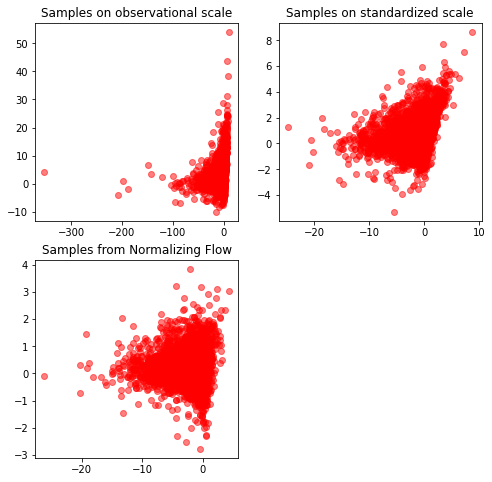

In [26]:
samples_obs, samples_std, samples_T= model.sample(n_samples)
plt.figure(figsize=(8,8))
plt.subplot(2, 2, 1)
plt.scatter(samples_obs[:,0].cpu().data.numpy(), samples_obs[:,1].cpu().data.numpy(), alpha=0.5, color='red')
plt.title('Samples on observational scale')
plt.subplot(2, 2, 2)
plt.scatter(samples_std[:,0].cpu().data.numpy(), samples_std[:,1].cpu().data.numpy(), alpha=0.5, color='red')
plt.title('Samples on standardized scale')
plt.subplot(2, 2, 3)
plt.scatter(samples_T[:,0].cpu().data.numpy(), samples_T[:,1].cpu().data.numpy(), alpha=0.5, color='red')
plt.title('Samples from Normalizing Flow')
plt.show()

In [69]:
np.mean(abs(samples_T[:,0].cpu().data.numpy() - samples_T[:,1].cpu().data.numpy()))

2.7414267

/tmp/ipykernel_4112495/2014099692.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(samples[:,0], hist=False, kde=True,
/tmp/ipykernel_4112495/2014099692.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(samples_obs[:,0].cpu().data.numpy(), hist=False, kde=True,
/tmp/ipyker

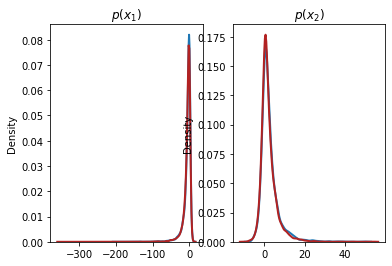

In [27]:
plt.subplot(1, 2, 1)
sns.distplot(samples[:,0], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(samples_obs[:,0].cpu().data.numpy(), hist=False, kde=True,
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
plt.title(r'$p(x_1)$')
plt.subplot(1, 2, 2)
sns.distplot(samples[:,1], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(samples_obs[:,1].cpu().data.numpy(), hist=False, kde=True,
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
plt.title(r'$p(x_2)$')
plt.show()

/tmp/ipykernel_4112495/4241041132.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(samples[:,1], hist=False, kde=True,
/tmp/ipykernel_4112495/4241041132.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(samples_obs[:,1].cpu().data.numpy(), hist=False, kde=True,
/tmp/ipyker

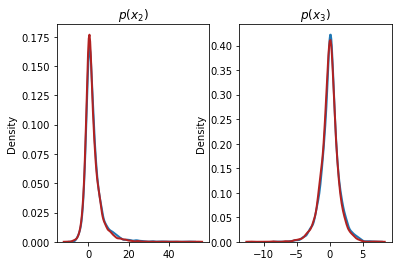

In [28]:
plt.subplot(1, 2, 1)
sns.distplot(samples[:,1], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(samples_obs[:,1].cpu().data.numpy(), hist=False, kde=True,
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
plt.title(r'$p(x_2)$')
plt.subplot(1, 2, 2)
sns.distplot(samples[:,2], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(samples_obs[:,2].cpu().data.numpy(), hist=False, kde=True,
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
plt.title(r'$p(x_3)$')
plt.show()

/tmp/ipykernel_4112495/2750042126.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(samples[:,0], hist=False, kde=True,
/tmp/ipykernel_4112495/2750042126.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(samples_obs[:,0].cpu().data.numpy(), hist=False, kde=True,
/tmp/ipyker

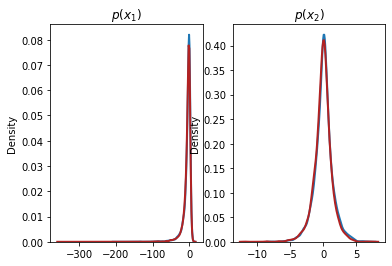

In [29]:
plt.subplot(1, 2, 1)
sns.distplot(samples[:,0], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(samples_obs[:,0].cpu().data.numpy(), hist=False, kde=True,
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
plt.title(r'$p(x_1)$')
plt.subplot(1, 2, 2)
sns.distplot(samples[:,2], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(samples_obs[:,2].cpu().data.numpy(), hist=False, kde=True,
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
plt.title(r'$p(x_2)$')
plt.show()

/tmp/ipykernel_4112495/2640502362.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(samples[:,0], hist=False, kde=True,
/tmp/ipykernel_4112495/2640502362.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(samples_obs[:,0].cpu().data.numpy(), hist=False, kde=True,
/tmp/ipyker

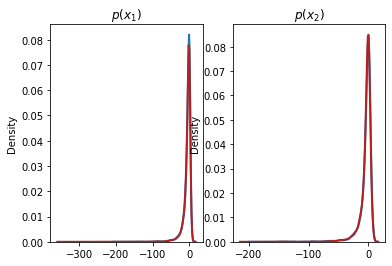

In [30]:
plt.subplot(1, 2, 1)
sns.distplot(samples[:,0], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(samples_obs[:,0].cpu().data.numpy(), hist=False, kde=True,
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
plt.title(r'$p(x_1)$')
plt.subplot(1, 2, 2)
sns.distplot(samples[:,3], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(samples_obs[:,3].cpu().data.numpy(), hist=False, kde=True,
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
plt.title(r'$p(x_2)$')
plt.show()

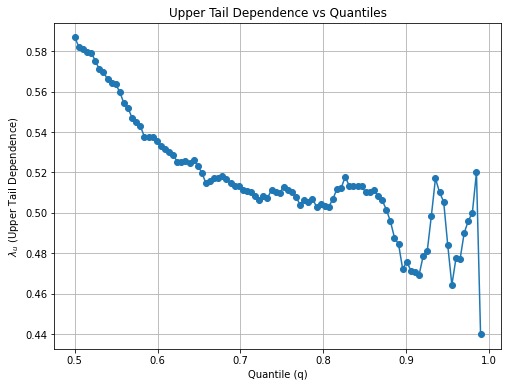

Empirical upper tail dependence: 0.44


In [31]:
def empirical_upper_tail_dependence(X1, X2, q):
    """
    Calculate empirical upper tail dependence coefficient.

    Parameters:
    X1, X2 : numpy arrays
        Samples from two random variables.
    q : float
        Quantile threshold (close to 1, e.g., 0.95 or 0.99).

    Returns:
    lambda_u : float
        Empirical upper tail dependence coefficient.
    """
    # Compute the quantiles
    F1_q = np.quantile(X1, q)
    F2_q = np.quantile(X2, q)
    
    # Count joint exceedances
    joint_exceedance = np.sum((X1 > F1_q) & (X2 > F2_q))
    exceedance_X1 = np.sum(X1 > F1_q)
    
    # Calculate lambda_u
    if exceedance_X1 == 0:  # Avoid division by zero
        return 0.0
    lambda_u = joint_exceedance / exceedance_X1
    return lambda_u


def plot_tail_dependence(X1, X2, quantiles):
    """
    Plot upper tail dependence vs quantiles.

    Parameters:
    X1, X2 : numpy arrays
        Samples from two random variables.
    quantiles : list or array
        List of quantiles to evaluate (e.g., np.linspace(0.9, 0.99, 50)).
    """
    # Compute lambda_u for each quantile
    lambda_values = [empirical_upper_tail_dependence(X1, X2, q) for q in quantiles]
    
    # Plot the results
    plt.figure(figsize=(8, 6))
    plt.plot(quantiles, lambda_values, marker='o', linestyle='-')
    plt.xlabel('Quantile (q)')
    plt.ylabel(r'$\lambda_u$ (Upper Tail Dependence)')
    plt.title('Upper Tail Dependence vs Quantiles')
    plt.grid(True)
    plt.show()

# Example usage
np.random.seed(42)
X1 = samples[:,0]
X2 = samples[:,1]

# Define quantiles (e.g., from 0.90 to 0.99)
quantiles = np.linspace(0.50, 0.990, 100)

# Plot the tail dependence
plot_tail_dependence(X1, X2, quantiles)
# Compute lambda_u at 0.95 quantile
q = 0.99
lambda_u = empirical_upper_tail_dependence(X1, X2, q)
print(f"Empirical upper tail dependence: {lambda_u}")

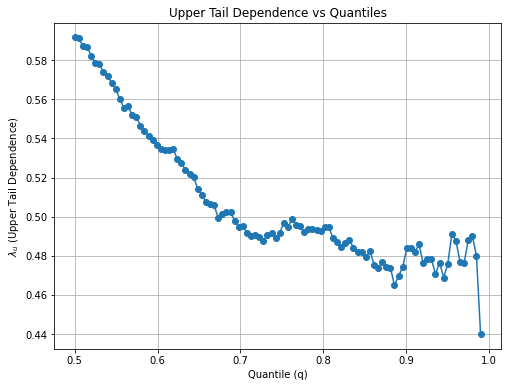

Empirical upper tail dependence: 0.44


In [32]:
X1 = samples_obs[:,0].cpu().data.numpy()
X2 = samples_obs[:,1].cpu().data.numpy()

# Define quantiles (e.g., from 0.90 to 0.99)
quantiles = np.linspace(0.50, 0.990, 100)

# Plot the tail dependence
plot_tail_dependence(X1, X2, quantiles)
# Compute lambda_u at 0.95 quantile
q = 0.99
lambda_u = empirical_upper_tail_dependence(X1, X2, q)
print(f"Empirical upper tail dependence: {lambda_u}")